# 0.0 Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pylab as pl

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier, plot_tree

from IPython.display import Image

import pickle

import time
import warnings

# Tempo de processamento
time_agora = time.time()

###### 0.1 Helper Functions

In [2]:
# Função buscar outlier pelo método do 6 Sigma
def buscar_outlier(df, series):
    média = df[series].mean()
    desvio_padrão = df[series].std()
    lis = média - (desvio_padrão * 3)
    lss = média + (desvio_padrão * 3)
    lista_outliers = df[(df[series] < lis) | (df[series] > lss)].index
    return lista_outliers, lis, lss

###### 0.3 Loading Dataset

In [3]:
df_raw = pd.read_csv(r'D:\\My Drive\\Pessoal\\Projetos\\insurance_sales_predict\\insurance_sales_predict\\data\\raw\\train.csv')

test = df_raw.sample(frac=0.1)
test_indices = test.index
df = df_raw.drop(test_indices)
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


# 1.0 Data Description

In [4]:
backup = df.copy()

### 1.1 Columns to Lowercase

In [5]:
cols = ' '.join(df.columns.to_list()).lower().split()

df.columns = cols

### 1.2 Data Dimensions

In [6]:
print(f'Number of rows: {df.shape[0]}')
print(f'Number of columns: {df.shape[1]}')

Number of rows: 342998
Number of columns: 12


### 1.3 Data Types

In [7]:
df.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

### 1.4 Check Na

In [8]:
df.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

### 1.5 Descriptive Statistical

###### 1.5.1 Classifying Attributes

In [9]:
features_categóricas = ['gender', 'vehicle_damage', 'vehicle_age', 'driving_license', 'region_code', 'previously_insured', 'policy_sales_channel', 'vintage']
features_numéricas = ['age', 'annual_premium']

###### 1.5.2 Target

In [10]:
print(f'A porcentagem de interessados no produto é: {round(df["response"].mean(), 2) * 100} %')

A porcentagem de interessados no produto é: 12.0 %


Desbalanceada

###### 1.5.3 Numerical Features

In [11]:
# Central tendency
ct1 = pd.DataFrame(df[features_numéricas].apply(np.mean)).T
ct2 = pd.DataFrame(df[features_numéricas].apply(np.median)).T

# Dispersion
d1 = pd.DataFrame(df[features_numéricas].apply(np.std)).T
d2 = pd.DataFrame(df[features_numéricas].apply(min)).T
d3 = pd.DataFrame(df[features_numéricas].apply(max)).T
d4 = pd.DataFrame(df[features_numéricas].apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(df[features_numéricas].apply(lambda x: x.skew())).T
d6 = pd.DataFrame(df[features_numéricas].apply(lambda x: x.kurtosis())).T

# Concat
temp = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T
temp.columns = 'min max range mean median std skew kurtosis'.split()
temp

,min,max,range,mean,median,std,skew,kurtosis
age,20.0,85.0,65.0,38.821148,36.0,15.508313,0.672407,-0.565649
annual_premium,2630.0,540165.0,537535.0,30571.002507,31671.0,17231.082652,1.837455,35.938529


* Range de idade entre 20 e 85 anos, sem indícios de erros de inputs
* Annual_Premium com possíveis outliers

In [12]:
df[features_numéricas].describe().T

,count,mean,std,min,25%,50%,75%,max
age,342998.0,38.821148,15.508336,20.0,25.00,36.0,49.0,85.0
annual_premium,342998.0,30571.002507,17231.107771,2630.0,24413.25,31671.0,39392.0,540165.0


* Idade com média e mediana próximas, dados centralizados na média, skew baixa, o que reforça distribuição centralizada na média, skew pouco positiva, o que sugere cauda esquerda mais pesada, kurtosis baixa e negativa, o que sugere uma distribuição um pouco mais plana em relação a uma normal com mesma média e desvio padrão, uma distribuição próxima a uma NORMAL
* Prêmio Anual com média e mediana próximos, o que sugere dados centralizados na média, skew baixa e positiva, o que sugere dados centralizados na média com uma cauda esquerda mais pesada, kurtosis bastante alto, o que sugere um pico bastante elevado, uma distribuição próxima a uma POISSON

###### 1.5.4 Categorical Features

In [13]:
df[features_categóricas].astype('category').describe().T

,count,unique,top,freq
gender,342998,2,Male,185458
vehicle_damage,342998,2,Yes,173185
vehicle_age,342998,3,1-2 Year,180155
driving_license,342998,2,1,342281
region_code,342998.0,53.0,28.0,95783.0
previously_insured,342998,2,0,185788
policy_sales_channel,342998.0,154.0,152.0,121488.0
vintage,342998,290,256,1290


* Sexo relativamente balanceado com a maioria de mulheres
* Maior parte dos clientes possuem veículos com menos de 1 ano
* Maior parte dos clientes já teve danos em seu veículo
* Habilitação para dirigir balanceado
* Há 53 regiões diferentes e por volta de 30% dos clientes estão contidos na região 28
* Um pouco mais que 50% dos clientes não possuem seguro veicular
* Há 157 canais de vendas, e por volta de 35% dos clientes estão contidos no canal 152.

# 2.0 Feature Engineering

### 2.1 Business Hypothesis

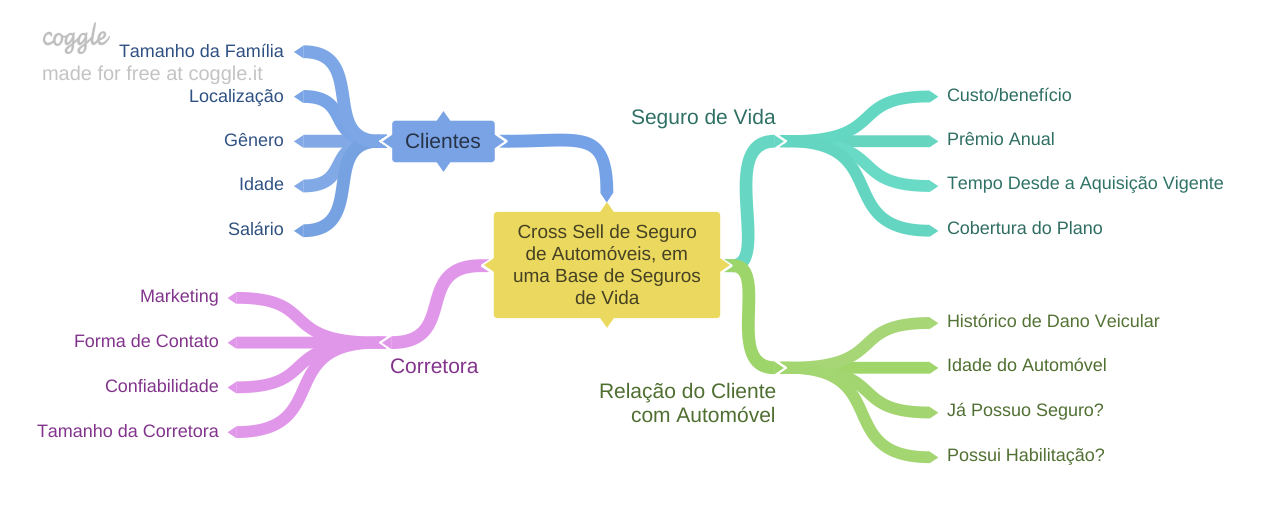

In [14]:
Image('D:\\My Drive\\Pessoal\\Projetos\\insurance_sales_predict\\insurance_sales_predict\\img\\mindmap.JPG')

### 2.2 Creating Hypothesis

###### Corretora:
* Contatos mais diretos com os clientes deveriam gerar mais vendas
* Ações de marketing deveriam gerar mais vendas.
* Contato mais próximo com o cliente deveriam gerar mais vendas
* Maior confiabilidade da parte da corretora deveria gerar mais vendas.

###### Clientes:
* Clientes localizados em regiões com maiores rendas percaptas deveriam comprar mais
* Clientes do gênero feminino deveriam comprar mais
* Clientes mais velhos deveriam comprar mais
* Clientes com famílias maiores deveriam comprar mais

###### Seguro de Vida:
* Contas de Seguro de Vida com valores mais altos deveriam gerar mais vendas
* Contas com tempo de aquisição vigente maior deveriam gerar mais vendas

###### Relação do Cliente com o Automóvel:
* Clientes que já acionaram o seguro no passado deveriam comprar mais
* Clientes com veículos mais novos deveriam comprar mais
* Clientes que não possuem seguro de automóvel deveriam comprara mais.
* Clientes habilitados deveriam comprar mais.

###### Hipóteses Selecionadas:

### 2.3 Creating Features

# 3.0 Data Filtering

## 3.1 Columns

In [15]:
df.drop('id', axis=1, inplace=True)

## 3.2 Rows

# 4.0 Exploratory Data Analysis

## Principais Insights:

### Espaço Amostral
* 6 dimensões parecem explicar 90% de toda variabilidade das features
* Annual_Premium transformada por log apresenta uma shape semelhante a uma normal
* 4 features binárias, 2 numéricas, 1 categórica e 2 categóricas com excessivas categorias e portanto foram transformadas em numéricas.

### Features Analysis

###### Response:
* Desbalanceada com 12% de eventos positivos

###### Gender:
* Balanceada
* Homens se interessam 30% mais no produto em relação às mulheres

###### Vehicle_Age:
* Mais da metade dos clientes possuem carros com menos de 1 ano
* Médias de response bastante distintas

###### Vehicle_Damage:
* Balanceada
* Clientes que já tiveram danos no seu veículo tem 24% de response, enquanto clientes que não tiveram danos têm por volta de 1%

###### Driving_License:
* 99% dos clientes são habilitados
* Habilitados apresentam 5% de interesse no produto, não habilitados apresentam 12% de interesse no produto.

###### Previously_Insured:
* 45% dos clientes já possuem seguro veicular
* Clientes que já possuem seguro têm interesse quase zero pelo produto

###### Region_Code:
* 53 regiões
* 28% dos clientes está contido na região 28. 50% dos dados estão contidos nas 5 regiões mais numerosas
* A região 28 (mais importante) tem por volta de 18% de probabilidade de response, segunda melhor região, atrás apenas da região 38.
* As regiões com probabilidade de response mais alto estão com por volta de 19%, as regiões com probabilidades mais baixas estã em por volta de 4%
* Médias de response bastante distintas, com desvios padrões baixos

###### Policy_Sales_Channel:
* Há 157 Policy_Sales_Channel e aproximadamente um terço das amostras está contido no canal 152
* 5 categorias contém 84.19% do total de clientes
* Médias de response por canais de Policy_Sales_Channel bastante distintas
* Os canais mais utilizados apresentam médias de response bastante diferentes da média global, os canal 152 é o mais utilizado e apresenta 2% de interesse no produto, o canal 155 apresenta 2%, já os canais 26, 124 e 156 apresentam por volta de 20% de interesse no produto

###### Vintage:
* Feature categórica, há 290 categorias em Vintage

###### Age:
* Range de idade de 25 até 85 anos, aparentemente sem erros de input
* Apresenta uma distribuição com uma certa semelhança com uma Poison, mas com uma segunda moda em um ponto próximo aos 45 anos.
* Sem outliers
* A média de idade entre os que não se interessam pelo produto é de 38 anos, e dos que se interessam é de 43 anos.
* Pessoas com mais de 30 anos apresentam um interesse relativamente maior pelo produto.
* Clientes com menos de 30 anos de idade apresentam em média 4% de interesse no produto, enquanto os clientes com 30 anos ou mais têm em média 17% interesse no produto.


###### Annual_Premium
* 2799 em Annual_Premmium, não aparentam ser por conta de erros de input
* Há dois grupos de clientes, um com valores fixos em 2630 dollares, e outro com valores contínuos e superiores, não há diferença significativa de média de interesse no produto entre os grupos
* Acima do terceiro quartil da distribuição há um interesse relativo 20% maior no produto

## 4.2 Univariate Analysis

#### response

In [16]:
df['response'].mean()

0.12245552452200888

#### gender

In [17]:
print(f'{round(df.loc[df["gender"]==0, "response"].mean() *100, 2)}% das mulheres se interessam pelo produto.')
print(f'{round(df.loc[df["gender"]==1, "response"].mean() *100, 2)}% dos homens se interessam pelo produto.')

nan% das mulheres se interessam pelo produto.
nan% dos homens se interessam pelo produto.


#### age

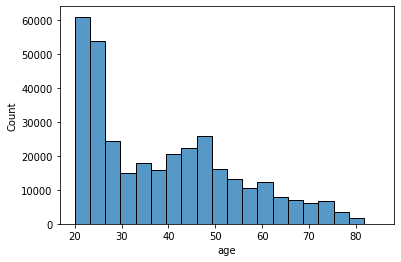

In [18]:
sns.histplot(df['age'], bins=20);

Apresenta uma distribuição com uma certa semelhança com uma Poison, mas com uma segunda moda em um ponto próximo aos 45 anos.

In [19]:
índices, li, ls = buscar_outlier(df, 'age')

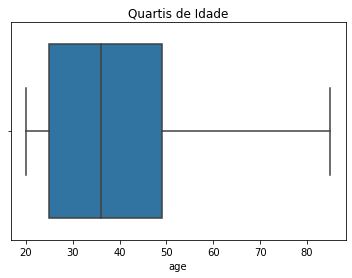

In [20]:
sns.boxplot(data=df, x='age')
plt.title('Quartis de Idade');

sem outliers

In [21]:
print(f'A média de idade entre os que NÃO se interessam pelo produto: {round(df.loc[df["response"]==0, "age"].mean(), 2)}%')
print(f'A média de idade entre os que se interessam pelo produto: {round(df.loc[df["response"]==1, "age"].mean(), 2)}%')

A média de idade entre os que NÃO se interessam pelo produto: 38.18%
A média de idade entre os que se interessam pelo produto: 43.45%


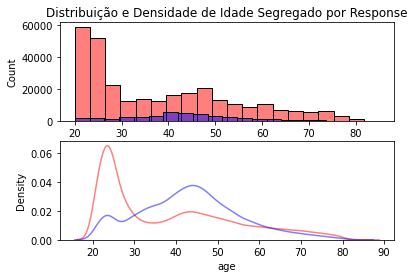

In [22]:
plt.subplot(2, 1, 1)
plt.title('Distribuição e Densidade de Idade Segregado por Response')
g = sns.histplot(df.loc[df['response']==0, 'age'], color='r', alpha=0.5, bins=20)
g = sns.histplot(df.loc[df['response']==1, 'age'], color='b', alpha=0.5, bins=20)
plt.subplot(2, 1, 2)
g = sns.kdeplot(df.loc[df['response']==0, 'age'], color='r', alpha=0.5)
g = sns.kdeplot(df.loc[df['response']==1, 'age'], color='b', alpha=0.5)

Pessoas mais velhas apresentam maior interesse no produto

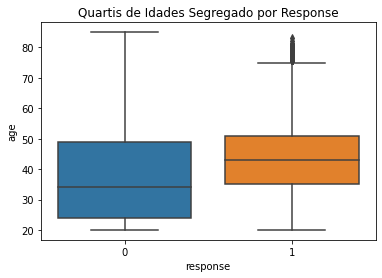

In [23]:
sns.boxplot(x='response', y='age', data=df)
plt.title('Quartis de Idades Segregado por Response');

Pessoas mais velhas apresentam interesse maior pelo produto

#### driving_license

In [24]:
print(f'{round(df["driving_license"].mean(), 3)}% dos clientes são habilitados')

0.998% dos clientes são habilitados


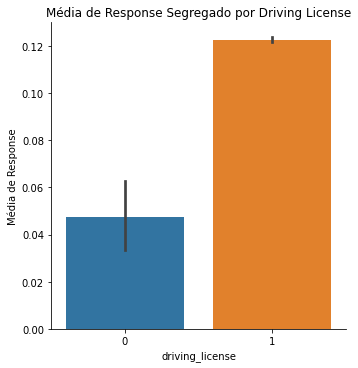

In [25]:
sns.catplot(x='driving_license', y= 'response', data=df, kind='bar')
plt.ylabel('Média de Response')
plt.title('Média de Response Segregado por Driving License');

In [26]:
print(f'Habilitados tem: {round(df.loc[df["driving_license"]==0, "response"].mean()*100, 2)}% de interesse no produto')
print(f'NÃO habilitados tem: {round(df.loc[df["driving_license"]==1, "response"].mean()*100, 2)}% de interesse no produto')

Habilitados tem: 4.74% de interesse no produto
NÃO habilitados tem: 12.26% de interesse no produto


#### previously_insured

In [27]:
df['previously_insured'].mean()

0.4583408649613117

45% dos clientes já sofreram danos veiculares

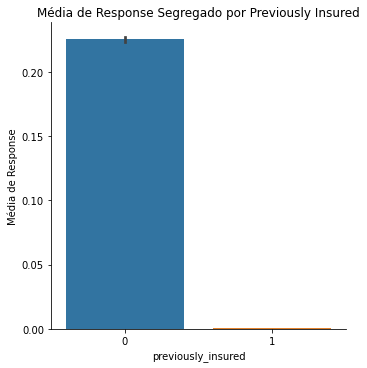

In [28]:
sns.catplot(x='previously_insured', y='response', data=df, kind='bar')
plt.title('Média de Response Segregado por Previously Insured')
plt.ylabel('Média de Response');

In [29]:
df.loc[df['previously_insured']==1, 'response'].mean()*100

0.09350550219451688

Clientes que possuem seguro veicular tem interesse quase zero no produto

#### region_code

In [30]:
df['region_code'].nunique()

53

53 categorias

In [31]:
df['region_code'].value_counts(normalize=True).head(5)

28.0    0.279252
8.0     0.088829
46.0    0.051817
41.0    0.047884
15.0    0.034811
Name: region_code, dtype: float64

In [32]:
df['region_code'].value_counts(normalize=True).tail(5)

1.0     0.002659
44.0    0.002096
42.0    0.001580
52.0    0.000708
51.0    0.000478
Name: region_code, dtype: float64

In [33]:
df['region_code'].value_counts(normalize=True).head(5).sum()

0.5025918518475327

28% dos clientes está contido na região 28. 50% dos dados estão contidos nas 5 regiões mais densas.

In [34]:
df.groupby('region_code', as_index=False).agg({'response':'mean'}).sort_values('response', ascending=False).head(5)

,region_code,response
38,38.0,0.192731
28,28.0,0.186599
19,19.0,0.161616
4,4.0,0.159303
23,23.0,0.155318


In [35]:
df.groupby('region_code', as_index=False).agg({'response':'mean'}).sort_values('response', ascending=False).tail(5)

,region_code,response
22,22.0,0.062818
50,50.0,0.061585
10,10.0,0.061136
25,25.0,0.044078
44,44.0,0.040334


As regiões com probabilidade de response mais alto estão com por volta de 19%, as regiões com probabilidades mais baixas estã em por volta de 4%

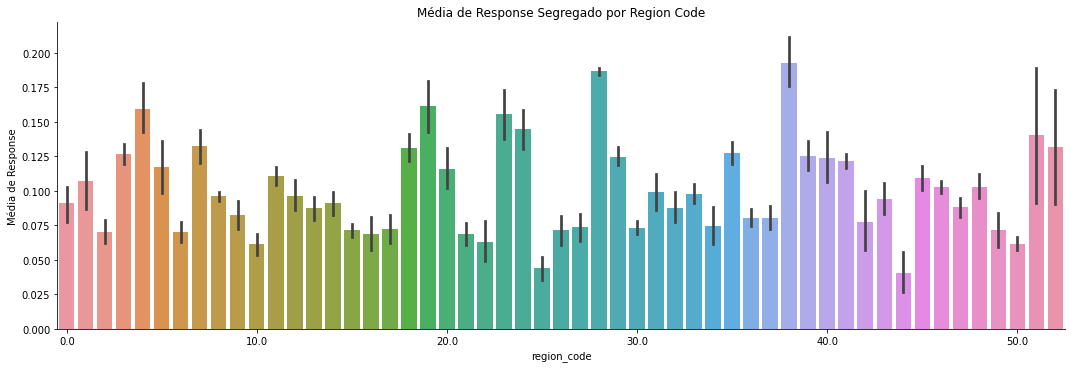

In [36]:
sns.catplot(x='region_code', y='response', data=df, kind='bar', aspect=3)
plt.title('Média de Response Segregado por Region Code')
plt.xticks(range(0, int(df['region_code'].max()), 10))
plt.ylabel('Média de Response');

Médias de response bastante distintas, com desvios padrões baixos

#### vehicle_age

In [37]:
df['vehicle_age'].value_counts(normalize=True)

1-2 Year     0.525236
< 1 Year     0.432548
> 2 Years    0.042216
Name: vehicle_age, dtype: float64

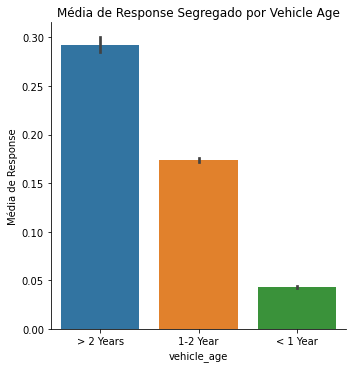

In [38]:
sns.catplot(x='vehicle_age', y='response', data=df, kind='bar')
plt.ylabel('Média de Response')
plt.title('Média de Response Segregado por Vehicle Age');

Médias de response bastante distintas

#### vehicle_damage

In [39]:
df['vehicle_damage'].value_counts(normalize=True)

Yes    0.504915
No     0.495085
Name: vehicle_damage, dtype: float64

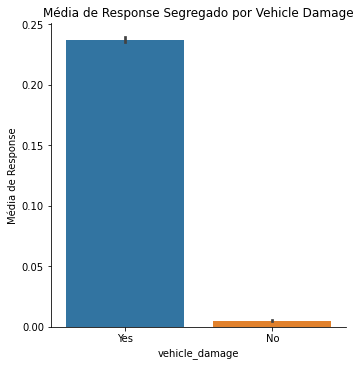

In [40]:
sns.catplot(x='vehicle_damage', y='response', data=df, kind='bar')
plt.title('Média de Response Segregado por Vehicle Damage')
plt.ylabel('Média de Response');

In [41]:
print(f'Clientes que já tiveram danos tem: {round(df.loc[df["vehicle_damage"]=="Yes", "response"].mean()*100, 2)}% de response')
print(f'Clientes que NÃO tiveram danos tem: {round(df.loc[df["vehicle_damage"]=="No", "response"].mean()*100, 2)}% de response')

Clientes que já tiveram danos tem: 23.74% de response
Clientes que NÃO tiveram danos tem: 0.52% de response


Clientes que já tiveram danos no seu veículo tem 24% de response, enquanto clientes que não tiveram danos têm por volta de 1%

#### annual_premium

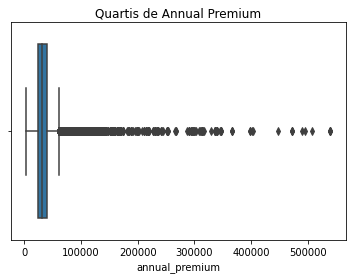

In [42]:
sns.boxplot(x='annual_premium', data=df)
plt.title('Quartis de Annual Premium');

Muitos outliers

In [43]:
índices, li, ls = buscar_outlier(df, 'annual_premium')

print(f'Há {len(índices)} outliers no total')

Há 1889 outliers no total


In [44]:
df.corr()['annual_premium'].sort_values(ascending=False)[1:]

age                     0.067265
response                0.022181
previously_insured      0.004791
vintage                -0.000599
region_code            -0.010310
driving_license        -0.012030
policy_sales_channel   -0.113167
Name: annual_premium, dtype: float64

Correlações muito fracas

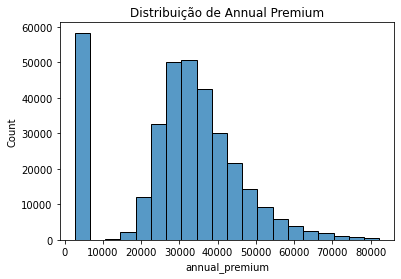

In [45]:
sns.histplot(df.drop(índices)['annual_premium'], bins=20)
plt.title('Distribuição de Annual Premium');

Com exceção das amostras com valor mais baixo (fixo), a distribuição é bastante parecida com uma normal

In [46]:
df['annual_premium'].value_counts(normalize=True).head(5)

2630.0     0.170016
69856.0    0.000376
39008.0    0.000099
43707.0    0.000099
38287.0    0.000096
Name: annual_premium, dtype: float64

17% dos clientes estão contidos em um valor discreto de 2630 dollares. Um estudo separadamente para este grupo pode ser interessante.

In [47]:
print(f'A média de interesse no produto do grupo de clientes com valor FIXO de seguro: {round(df.loc[df["annual_premium"]==2630, "response"].mean()*100, 2)}%')
print(f'A média de interesse no produto do grupo de clientes com valor VARIÁVEL SUPERIOR de seguro: {round(df.loc[df["annual_premium"]!=2630, "response"].mean()*100, 2)}%')

A média de interesse no produto do grupo de clientes com valor FIXO de seguro: 13.11%
A média de interesse no produto do grupo de clientes com valor VARIÁVEL SUPERIOR de seguro: 12.07%


O interesse no produto não é significativamente diferente entre os dois grupos de clientes

Para uma melhor visualização, os dados serão filtrados provisioriamente até 100000 dollares

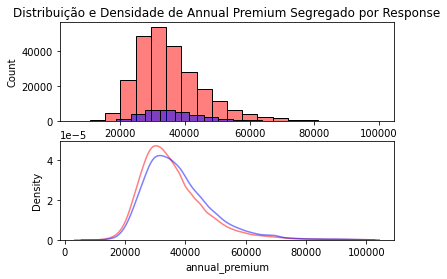

In [48]:
temp = df.loc[(df['annual_premium']>2630)&(df['annual_premium']<100000)]

plt.subplot(2, 1, 1)
plt.title('Distribuição e Densidade de Annual Premium Segregado por Response')
g = sns.histplot(temp.loc[temp['response']==0, 'annual_premium'], color='r', alpha=0.5, bins=20)
g = sns.histplot(temp.loc[temp['response']==1, 'annual_premium'], color='b', alpha=0.5, bins=20)
plt.subplot(2, 1, 2)
g = sns.kdeplot(temp.loc[temp['response']==0, 'annual_premium'], color='r', alpha=0.5)
g = sns.kdeplot(temp.loc[temp['response']==1, 'annual_premium'], color='b', alpha=0.5)

Aparentemente acima do terceiro quartil da distribuição há um interesse maior no produto

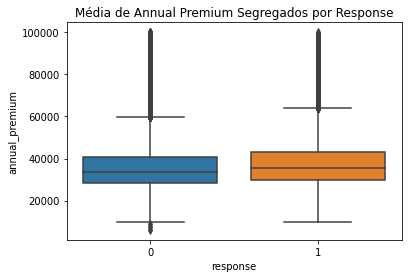

In [49]:
plt.title('Média de Annual Premium Segregados por Response')
sns.boxplot(x='response', y='annual_premium', data=temp);

Sem diferença significativa

#### policy_sales_channel

In [50]:
df['policy_sales_channel'].value_counts(normalize=True).head(5)

152.0    0.354194
26.0     0.209004
124.0    0.193817
160.0    0.056995
156.0    0.027927
Name: policy_sales_channel, dtype: float64

In [51]:
canais_mais_utilizados = df['policy_sales_channel'].value_counts(normalize=True).head(5).index

In [52]:
print(f'5 categorias contém {round(df["policy_sales_channel"].value_counts(normalize=True).head(5).sum()*100, 2)}% do total de clientes')

5 categorias contém 84.19% do total de clientes


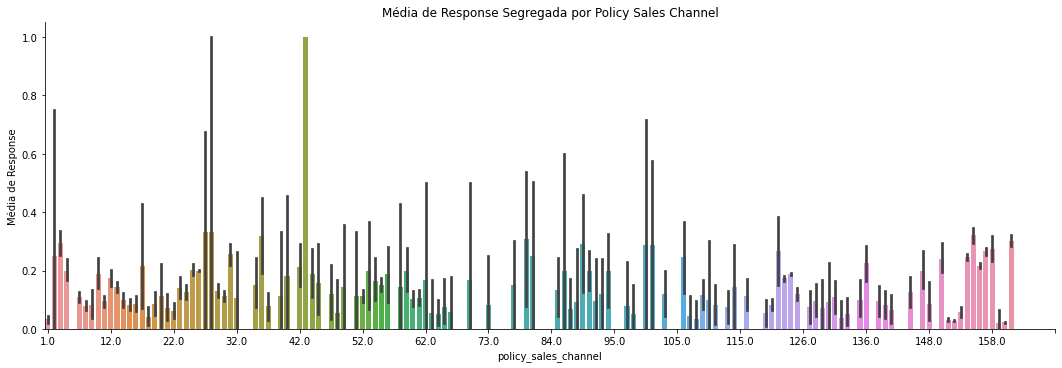

In [53]:
sns.catplot(x='policy_sales_channel', y='response', data=df, kind='bar', aspect=3)
plt.xticks(range(0, int(df['policy_sales_channel'].max()), 10))
plt.title('Média de Response Segregada por Policy Sales Channel')
plt.ylabel('Média de Response');

Médias de response por canais de Policy_Sales_Channel bastante distintas

In [54]:
temp = df.groupby('policy_sales_channel', as_index=False).agg({'response':'count'})
temp.rename(columns={'response':'response_count'}, inplace=True)

temp2 = df.groupby('policy_sales_channel', as_index=False).agg({'response':'mean'})
temp2.rename(columns={'response':'response_mean'}, inplace=True)

temp3 = temp.merge(temp2, how='left', on='policy_sales_channel')
temp3.sort_values('response_count', ascending=False).head(5)

,policy_sales_channel,response_count,response_mean
144,152.0,121488,0.028455
24,26.0,71688,0.199936
118,124.0,66479,0.188932
152,160.0,19549,0.022047
148,156.0,9579,0.216202


Os canais mais utilizados apresentam médias de response bastante diferentes da média global, os canal 152 é o mais utilizado e apresenta 2% de interesse no produto, o canal 155 apresenta 2%, já os canais 26, 124 e 156 apresentam por volta de 20% de interesse no produto

#### vintage

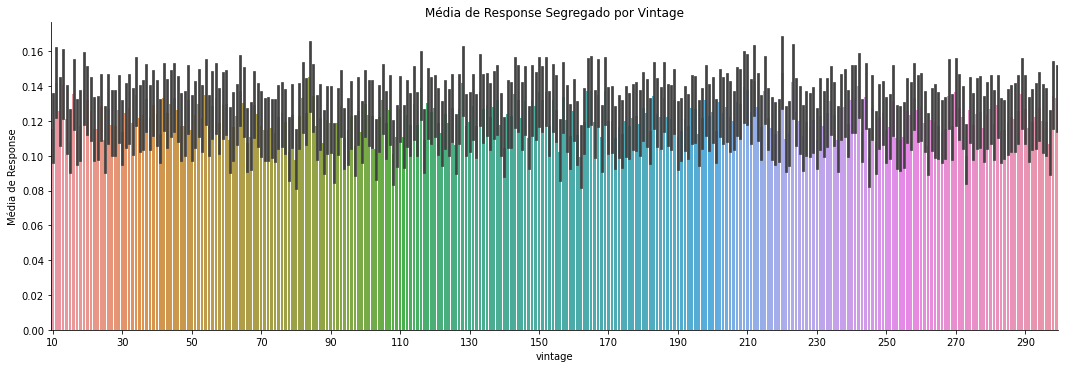

In [55]:
sns.catplot(x='vintage', y='response', data=df, kind='bar', aspect=3)
plt.title('Média de Response Segregado por Vintage')
plt.ylabel('Média de Response')
plt.xticks(range(0, df['vintage'].max(), 20));

Muito ruidoso, os desvios padrões colocam tudo no mesmo nível.

## 4.3 Bivariate Analysis

## 4.4 Multivariate Analysis

# 5.0 Exportings

###### 5.1 dataframes

In [56]:
# test
pickle.dump(test, open('D:\\My Drive\\Pessoal\\Projetos\\insurance_sales_predict\\insurance_sales_predict\\data\\raw\\test.pkl', 'wb'))

# dataframe
pickle.dump(df, open('D:\\My Drive\\Pessoal\\Projetos\\insurance_sales_predict\\insurance_sales_predict\\data\\interim\\df_to_data_preparation.pkl', 'wb'))

# Time

In [57]:
print(f'O tempo de processamento do projeto foi de: {int(round(time.time()-time_agora, 2)/60)} minutos')

O tempo de processamento do projeto foi de: 0 minutos
